<a href="https://colab.research.google.com/github/Yoshi31/Data-structures/blob/main/AGAT_NLP_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Я доработаю задачу классификации токсических комментариев, на этот раз буду использовать BERT, для того, чтобы обработать текст и привести к векторному виду намного лучше.
Буду использовать colab, т.к. модель требует большего кол-ва памяти. Выполнение команд займет намного меньше времени именно в colab.

In [1]:
import pandas as pd
import numpy as np

In [3]:
data=pd.read_csv('https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv', sep='\t')
data.head()

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


In [4]:
data['should_ban'].value_counts(normalize=True)

1    0.508
0    0.492
Name: should_ban, dtype: float64

In [5]:
data['should_ban']=data['should_ban'].astype('int64')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   should_ban    1000 non-null   int64 
 1   comment_text  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Я нашел прекрасный датасет для моей тестовой задачи, он относительно мал, что позволит мне использовать его полностью в моей модели, не задумываясь о времени, которое уйдет на обработку

In [8]:
comment = data['comment_text'].values
toxic = data['should_ban'].values

In [9]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 27.1 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
     |████████████████████████████████| 3.3 MB 59.3 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 80.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import torch
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [84]:
os=SMOTE(random_state=0)
comment_train, comment_test, y_train, y_test = train_test_split(comment, toxic, test_size=0.3, random_state=0)

SMOTE использую для того, чтобы лучше разбить выборку

In [85]:
model_bert, tokenizer_bert, pretrain_weights=(
    ppb.DistilBertModel,
    ppb.DistilBertTokenizer,
    'distilbert-base-uncased'
)

При использовании BERT важно правильно выбрать веса для модели. Я выбирал их на https://huggingface.co/. Руководствуясь советами с habr и sof. остановился на distilbert-base-uncased, т.к. эта модель полезна, если мы хотим настроить ее для относительно простой задачи на Английском языке. Выбрал именно DistilBert, т.к. мне больше важна скорость, и у меня слабые вычислительные мощности.

In [86]:
tokenizer=tokenizer_bert.from_pretrained(pretrain_weights)
model=model_bert.from_pretrained(pretrain_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [87]:
comment_train_tokenized=[tokenizer.encode(x,add_special_tokens=True, truncation=True)for x in comment_train]

In [88]:
comment_test_tokenized=[tokenizer.encode(x,add_special_tokens=True, truncation=True)for x in comment_test]

Токенизация с помощью BERT выполняется по заранее обученной модели, это очень большой плюс этой модели. Длина последовательности индексов больше указанной длины для этой модели, поэтому мне пришлось использовать 'truncation=True'

In [89]:
def pad_comment(comment_tokenized):
    max_len = 0
    for i in comment_tokenized:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in comment_tokenized])
    return padded

Использую паддинг, чтобы привести векторы к одному размеру

In [90]:
padded_train = pad_comment(comment_train_tokenized)
padded_test = pad_comment(comment_test_tokenized)

In [91]:
np.array(padded_train).shape

(700, 512)

In [92]:
def attention_mask(padded_comment):
    return np.where(padded_comment != 0, 1, 0)

In [93]:
attention_mask_train = attention_mask(padded_train)
attention_mask_train.shape

(700, 512)

In [94]:
attention_mask_test = attention_mask(padded_test)
attention_mask_test.shape

(300, 512)

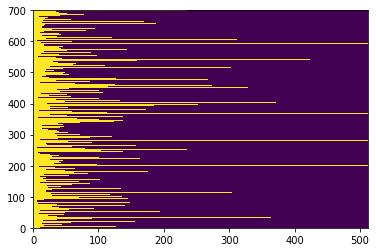

In [95]:
plt.pcolormesh(attention_mask_train)

In [96]:
model=model_bert.from_pretrained(pretrain_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [97]:
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [98]:
import tqdm

In [99]:
output=[]
batch_size=16
for idx in tqdm.tnrange(0,700,batch_size):
  batch=torch.tensor(padded_train[idx:idx+batch_size])
  local_attention_mask=torch.tensor(attention_mask_train[idx:idx+batch_size])

  with torch.no_grad():
    last_hidden_states=model(batch, attention_mask=local_attention_mask)[0][:,0,:].numpy()
    output.append(last_hidden_states)

  0%|          | 0/44 [00:00<?, ?it/s]

Использую небольшие батчи для того, чтобы код не крашнулся из-за нехватки памяти. Так-же намеренно не использую градиентный спуск. Т.к. модель уже заранее определила все. Градиентный спуск займент намного больше времени. В данном случае он не имеет смысла.

In [100]:
output_test=[]
batch_size=16
for idx in tqdm.tnrange(0,300,batch_size):
  batch=torch.tensor(padded_test[idx:idx+batch_size])
  local_attention_mask=torch.tensor(attention_mask_test[idx:idx+batch_size])

  with torch.no_grad():
    last_hidden_states=model(batch, attention_mask=local_attention_mask)[0][:,0,:].numpy()
    output_test.append(last_hidden_states)

  0%|          | 0/19 [00:00<?, ?it/s]

In [101]:
train_features=np.vstack(output)

In [102]:
test_features=np.vstack(output_test)

In [103]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, y_train)

LogisticRegression()

In [104]:
lr_clf.score(test_features, y_test)

0.89

Задачу с Kaggle оценивали именно по метрике auc, я собираюсь оценить свою модель по этой же метрике

In [105]:
from sklearn.metrics import roc_auc_score, roc_curve

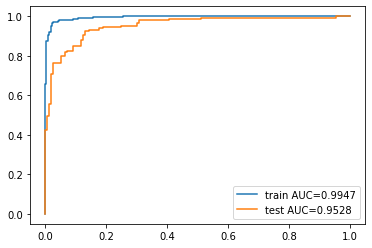

In [106]:
proba = lr_clf.predict_proba(train_features)[:, 1]
auc = roc_auc_score(y_train, proba)
plt.plot(*roc_curve(y_train, proba)[:2], label='%s AUC=%.4f' % ('train', auc))
proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(y_test, proba)
plt.plot(*roc_curve(y_test, proba)[:2], label='%s AUC=%.4f' % ('test', auc))
plt.legend()

Мы получили очень хорошие показатели для нашего датасета. Они могли быть лучше, если бы вместо distilbert я бы использовал обычный bert, так-же можно поэксперементировать с различными весами и гиперпараметрами. BERT очень полезный алгоритм для работы в NLP, сейчас он активно развивается и постоянно дорабатывается.